In [1]:
# Se importan las librerías necesarias para el progama.

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from numpy import random as rd
import komm

## Fuente de información

La fuente de información utilizada en este proyecto es una imagen. Esta imagen debe hallarse en la misma carpeta que el código fuente. La imagen es leída por medio de la biblioteca PIL y se pasa a un array de NumPy que contiene los valores RGB de la foto.

In [2]:
def fuente_informacion(foto):
    '''
    La función tiene como objetivo ser la fuente de información.
    Se lee una imagen de la computadora para almacenarla en un
    array de NumPy donde se tienen las dimensiones de la imagen
    y sus canales RGB.

    @param foto: Archivo de imagen
    return fuente: Vector de pixeles
    '''
    # Se lee el archivo
    fuente = Image.open(foto)

    return np.array(fuente) # Se crea un array de pixeles

## Codificador de fuente

Este bloque tiene como objetivo recibir la información de la imagen (RGB) y pasarla a bits. Lo que devuelve es una única cadena de bits con la información de los 3 canales de la imagen.

In [3]:
def pixel_a_bits(array_foto):
    '''
    Función para convertir los valores de los pixeles a binario
    como toman valores de 0 a 255 por el formato RGB, se utilizan
    8 bits para la codificación.

    @param array_foto: Array de una imagen
    return bits_Rx: Vector de bits
    '''
    # Dimensiones de la imagen
    alto, largo, canales = array_foto.shape

    # Cantidad de elementos en la imagen (pixeles x canales)
    cantidad_elementos = alto * largo * canales

    # Se pasa el array a un vector del tamaño (1 x cantidad_elementos)
    vector_elementos = np.reshape(array_foto, cantidad_elementos)

    # Se pasan los valores a binario, es una lista de strings donde cada elemento consiste en 1 byte.
    bits = [format(elemnto, '08b') for elemnto in vector_elementos]

    # Se dividen los bytes en bits, para obtener una lista entera de 1s y 0s
    bits_Rx = np.array(list(''.join(bits)))

    return bits_Rx.astype(int) # La lista se da en formato de int

## Codificación canal

Este bloque se encarga de separar la cadena de bits recibida por el codificador de fuente y separarla en vectores de tamaño 1 x k. Estos vectores se multiplican por la matriz G para obtener el vector $\overrightarrow{u}$. Este proceso se realiza con el objetivo de agregar más bits que permitan corregir el vector después de pasar por un canal ruidoso. La matriz G utilizada es la siguienta:

$$\begin{bmatrix} 0 & 1 & 1 & 0 & 1 & 0 & 0 & 0 \\ 1 & 1 & 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 1 & 0 & 1 & 0 & 0 & 1 & 0 \\ 1 & 1 & 1 & 1 & 0 & 0 & 0 & 1 \end{bmatrix}$$

In [4]:
def codificacion_canal(bits_Tx, matriz_G):
    '''
    Función de codificación de canal. Esta se encarga de recibir los bits de la codificación
    de canal y agregar más con el objetivo de corregir después del error agregado. Para ello,
    se hace uso de la matriz Generadora.
    
    @param bits_Tx: Cadena de bits enviada por el codificador de canal
    @param matriz_G: Matriz compuesta de la matriz identidad y paridad
    return u: Cadena de bits u
    '''
    # Cantidad de bits en la secuencia
    N = len(bits_Tx)
    
    # Se separa en los vectores m (1 x k)
    m = np.split(bits_Tx, N/4)
    
    # Se declara la lista de salida (vectores u)
    u = []
    
    # Se realiza la multiplicación: u = m * G
    for i in range(0, len(m)):
        u.append(m[i].dot(matriz_G) % 2)
        
    u = np.concatenate(u, axis=None)
        
    return u.astype(int)

## Modulación PAM

El modulador PAM puede ser analizado según su diagrama de bloques. Está compuesto por dos bloques, uno que pasa de bits a símbolos y otro que recibe los símbolos y da una amplitud determinada a un pulso. Se utilizará un modulador PAM de 2 bits, con cuatro símbolos que estarán separados por 2 unidades de forma que la tabla de correspondencia es la siguiente:

| Bits | Símbolo |
| :-: | :-: |
| 00 | 6 |
| 01 | 4 |
| 11 | 2 |
| 10 | 0 |

1. Agrupar b_c(l) en bloques de 2 bits, es decir b = 2
2. Asingar símbolos a bits en a(n)
3. Definir el pulso rectangular y guardar en variable p, Ns = 24 (lista de 24 1s)
4. Modular a(n), multiplicando el símbolo por un pulso rectangular
5. Multiplicar cada símbolo por el pulso y guardar en variable xn(k)
6. x(k) resulta de concatenar todos los xn(k)
7. Medir la longitud de la secuencia x(k) y comparar con b_c(l) 
8. x(k) debe ser Ns/b  veces mayor que b_c(l)

In [5]:
def modulador_PAM (bc_l):
    '''
    Función de modulador PAM de 2 bits, recibe bits a transmitir y los modula
    con la asignación:
    00 - 6
    01 - 4
    11 - 2
    10 - 0

    @param bc_l: Secuencia de bits proveniente del codificador de canal.
    return x_k: Señal modulada con la información que será enviada por el canal ruidoso.
    '''
    
    # Paso 1
    agrupacion_bits = np.split(bc_l, len(secuencia_codificada)/2)
    
    # Paso 2
    a_n = [] 
    
    for bits in agrupacion_bits:
        if bits[0] == 0:
            if bits[1] == 0:
                simbolo = 6
            else:
                simbolo = 4
        else:
            if bits[1] == 1:
                simbolo = 2
            else:
                simbolo = 0
        a_n.append(simbolo)
        
    # Paso 3
    p = np.ones(24)
    
    # Paso 4 y 5
    arrayOfxn_k = []
    
    for simbolo in a_n:
        xn_k = simbolo * p
        arrayOfxn_k.append(xn_k)
    
    # Paso 6
    x_k = np.concatenate(arrayOfxn_k, axis=None)
    
    return x_k.astype(int)


## Modulación ASK

En este caso, se emplea el tipo de modulación ASK. Esta modulación es de tipo digital pasa-banda, que consiste en utilizar una señal portadora como un seno o coseno, que contiene la información para poder ser enviada por un canal. En este caso, la función recibe como parámetros la secuencia de bits proveniente del codificador de canal, la frecuencia de la portada y el tiempo de símbolo. Este último se refiere a cuánto tiempo va a ocupar en la señal un símbolo, que sería la información enviada. En este caso, se utiliza la misma codificación del modulador PAM, donde se utilizan 4 símbolos. Seguidamente, se crea la señal portadora que consiste en un seno. Esta señal portadora se multiplica por el símbolo y se obtiene una amplitud diferente para cada uno de ellos. Por lo tanto, la señal enviada consiste en un seno con la misma frecuencia donde su amplitud va cambiando.

In [6]:
def modulador_ASK (bc_l, fs, tiempo_simbolo):
    '''
    Modulador ASK: utiliza un modulador PAM y multiplica por una señal portadora de frecuencia fc.

    @param bc_l: Bits del codificador de canal
    @param fs: Frecuencia de la portadora
    @param tiempo_simbolo: El tiempo de duración de cada símbolo

    return x_t: Señal transmitida al canal
    return tiempo: Vector de tiempo de la señal
    '''
    
    # Modulación de la amplitud
    bcT = modulador_PAM(bc_l)
    
    # Muestreo de amplitud
    i = 3 # Para muestrear el valor de cada símbolo en el de la posición 4, son 24 valores de amplitud por símbolo
    contador_simbolo = 0
    simbolos = [0] * (int(np.size(bcT, axis=0)/24)) # 24 porque son 24 valores de amplitud por símbolo
    
    while i < np.size(bcT, axis=0):
        simbolos[contador_simbolo] = bcT[i]
        contador_simbolo += 1
        i += 24
    
    # Definición de señal portadora
    tiempo = np.arange(0, tiempo_simbolo, (t_simb*2/fs))# se utiliza frecuencia de muestreo de nyquist ajustada al tiempo de símbolo
    c_t = np.sin(2 * np.pi * fs * tiempo)
    
    # Modulación en el tiempo
    i = 0
    arrayOfx_t = [0] * (len(simbolos))

    for simbolo in simbolos:
        arrayOfx_t[i] = c_t * simbolo
        i += 1
    
    x_t = np.concatenate(arrayOfx_t, axis=None)
    tiempo = len(x_t)
    print(x_t)
    print(type(x_t))
    
    return x_t, tiempo

## Canal ruidoso

Esta función modela un canal con ruido, como lo existe en todos los medios de comunicación. El ruido que se añade por este canal es por medio de la distribución normal, que se conoce como Ruido Blanco Gaussiano Aditivo, AWGN por sus siglas en inglés. Este ruido se le suma a la señal generada por el modulador PAM>

In [7]:
import numpy as np

def canal_ruidoso(senal_Tx, snr=0.2):
    '''Un bloque que simula un medio de trans-
    misión no ideal (ruidoso).

    @param senal_Tx: El vector del modulador
    return sneal_Rx: La señal modulada al dejar el canal
    '''

    # Generando ruido auditivo blanco gaussiano
    ruido = np.random.normal(0, 1/snr, senal_Tx.shape)

    # Señal distorsionada por el canal ruidoso
    senal_Rx = senal_Tx + ruido

    return senal_Rx

## Demodulación PAM

El demodulador PAM digital se puede considerar como una serie de 3 bloques. El primero de ellos es el de muestreo, que tiene por entrada la señal proveniente del canal (con ruido) y cada $T_{sim}$ obtiene una muestra del valor de la señal $y_n^*$. Seguidamente, se tiene el bloque de decisión que revisa los límites de cada símbolo y según el rango en el que se haya la muestra, le asigna uno de los símbolos mostrados en la tabla anterior. Por último, el último bloque recibe una cadena de símbolos que son convertidos a bits según la tabla ya propuesta.

![Diagrama](demodulador.JPG)

1. Se obtienen los valores del pulso de la señal en su tiempo de duración.
2. Se promedian los valores.
3. Comparar con los símbolos $a_i$ y decidir a cuál corresponde.
4. Se pasa la secuencia de símbolos a sus bits correspondientes.
5. Se crea una secuencia de bits que será la entrada del decodificador de canal.

In [8]:
def demodulador_PAM(senal_xR):
    '''
    Función del bloque demodulador. Este bloque se encarga de recibir la señal
    proveniente del canal, muestrear y promediar sus valores para finalmente
    asociar los símbolos correspondientes y pasarlos a bits.

    @param senal_xR: Señal proveniente del canal, con ruido.
    return bits_recuperados: Secuencia de bits correspondientes a la información obtenida del canal.
    '''
    
    # 1. Se crea una lista de listas con los valores de muestras para promediarlos
    muestras_separadas = np.split(senal_xR, len(senal_xR)/24)
    
    # 2. Se promedian las muestras en cada lista
    promedios = []
    suma = 0
    
    for list in muestras_separadas:
        for muestra in list:
            suma = suma + muestra
        promedio = suma/24
        promedios.append(promedio)
        suma = 0
        
    # 3. Con las muestras promediadas, se decida a cuál símbolo se asocia
    nuevos_simbolos = []
    for prom_simb in promedios:
        if prom_simb < 1:
            nuevos_simbolos.append(0)
        elif prom_simb >= 1 and prom_simb < 3:
            nuevos_simbolos.append(2)
        elif prom_simb >= 3 and prom_simb < 5:
            nuevos_simbolos.append(4)
        else:
            nuevos_simbolos.append(6)
            
    # 4. Pasamos los símbolos a bits
    bits_recuperados = []
    
    for simbolo in nuevos_simbolos:
        if simbolo == 0:
            bits_recuperados.append([1, 0])
        elif simbolo == 2:
            bits_recuperados.append([1, 1])
        elif simbolo == 4:
            bits_recuperados.append([0, 1])
        else:
            bits_recuperados.append([0, 0])
            
    bits_recuperados = np.concatenate(bits_recuperados, axis=None)
            
    return bits_recuperados.astype(int)

## Demodulación ASK

Esta demodulación ASK se parece en gran manera a la de PAM. La diferencia radica en el muestreo de la señal recibida. En este caso, como se está trabajando con una señal portadora seno, el muestreo realizado se realiza en los máximos y mínimos. Esto debido a que en estos puntos se halla el valor del símbolo que se envió, por ello se obtiene sus valores, los mínimos (negativos) se pasan a positivo con la función abs() y seguidamente se promedian los valores muestreados. Esta lista de valores promediados son los utilizados para proceder a la decisión de en qué símbolo consiste la información recibida. Los pasos siguientes son iguales a la ya vista demodulación PAM.

In [9]:
def demod_ASK(senal_xR, cant_simb, t_simb, fs):
    '''
    Función de demodulación ASK. Realiza un muestreo de la señal, decide que símbolo le asigna y finalmente pasa el símbolo a bits.

    @param senal_xR: Señal proveniente del canal ruidoso.
    @param cant_simb = Cantidad de símbolos enviados (información)
    @param t_simb: Tiempo de duración de cada símbolo.
    @param fs: Frecuencia de la portadora.

    return bits_recuperados: Los bits obtenidos del canal, después de la adición de ruido. Idealmente se corrigen en el decodificador de canal.
    '''
    # 1. Se divide la señal recibida en sublistas, donde cada una contiene todos los valores de un símbolo
    arrayOfSymbolsValue = np.split(senal_xR, cant_simb)

    # 2. Creo el vector tiempo, que es la duración de cada símbolo
    tiempo_demod = np.arange(0, t_simb, (t_simb*2/fs))

    # 3. Vector de símbolos muestreados
    array_simb = []

    # 4. Loop que obtiene los valores de los picos de la señal para cada símbolo. Con picos nos referimos
    # a los valores máximos y mínimos de la señal recibida. Como la portadora es un seno, los picos se dan
    # en pi/2 y 3pi/2.

    for senal_simb in arrayOfSymbolsValue:
        # Los picos se dan en valores impares de n
        n = 1
        # Array con los valores obtenidos
        muestreo = []
        for pos, val in enumerate(tiempo_demod):
            # Se revisa cuando el tiempo está en el rango donde se produce un pico
            if val > (n/(4*fs))*0.99 and val < (n/(4*fs))*1.01:
                # Se guarda en el array el valor de señal correspondiente a ese tiempo
                muestreo.append(senal_simb[pos])
                n += 2
            # Se pasan los valores a positivo y se promedia
            muestreo_abs = np.absolute(muestreo)
            muestreo_prom = np.mean(muestreo_abs)
            array_simb.append(muestreo_prom)

    
    # 5. Con las muestras promediadas, se decida a cuál símbolo se asocia
    nuevos_simbolos = []
    for prom_simb in array_simb:
        if prom_simb < 1:
            nuevos_simbolos.append(0)
        elif prom_simb >= 1 and prom_simb < 3:
            nuevos_simbolos.append(2)
        elif prom_simb >= 3 and prom_simb < 5:
            nuevos_simbolos.append(4)
        else:
            nuevos_simbolos.append(6)
            
    # 4. Pasamos los símbolos a bits
    bits_recuperados = []
    
    for simbolo in nuevos_simbolos:
        if simbolo == 0:
            bits_recuperados.append([1, 0])
        elif simbolo == 2:
            bits_recuperados.append([1, 1])
        elif simbolo == 4:
            bits_recuperados.append([0, 1])
        else:
            bits_recuperados.append([0, 0])
            
    bits_recuperados = np.concatenate(bits_recuperados, axis=None)

    return bits_recuperados.astype(int)

## Decodificación de canal

Este bloque recibe los bits después de ser demodulados. Estos bits provenien a su vez de un canal ruidoso, por lo que se espera hallan errores y la idea es corregirlos. Para ello, se utiliza otra matriz conocida por H. Esta matriz proviene de la misma matriz G ya vista, la idea es separar la cadena de bits recibida en vectores de tamaño 1 x u, y mutiplicarlos por la matriz. Con ello, hallar cual bit contiene error y corregirlo. La matriz H es la siguiente:

$$\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 1 & 1 & 0 \\ 1 & 1 & 0 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 1 & 1 &1 \end{bmatrix}$$

In [10]:
def decodificacion_canal(bits_recibidos, matriz_H):
    '''
    Esta función tiene como objetivo corregir errores creados por el canal ruidoso. Por lo tanto,
    se utiliza una matriz H para hallar en que posición se halla el error y poder corregirlo. Recibe
    la cadena de bits del demodulador y la matriz H.
    
    @param bits_recibidos: Cadena de bits enviada por el demodulador.
    @param matriz_H: Matriz H para la corrección de errores.
    return M_secuencia: Devuelve una cadena menor de bits con la información recuperada y corregida.
    '''
    # Cantidad de bits en la secuencia
    N = len(bits_recibidos)
    
    # Se separa en los vectores v (1 x n)
    v = np.split(bits_recibidos, N/8)
    
    # Se declara la lista de síndromes
    S = []
    
    # Se realiza la multiplicación v * H = S
    for i in range(0, len(v)):
        S.append(v[i].dot(matriz_H) % 2)
    
    # Se transforma S en un array de numpy
    S = np.array(S)

    # Se declara la lista que contiene los vectores Ux
    Ux = []
    
    # Se utiliza un loop que revisa el resultado del síndrome y corrige el error según la posición en la matriz.
    for sindrome in range(0, np.size(S, 0)):
        if (np.all(S[sindrome] == matriz_H[0, :])):
            Ux.append((v[sindrome] + [1, 0, 0, 0, 0, 0, 0, 0]) % 2)
        elif (np.all(S[sindrome] == matriz_H[1, :])):
            Ux.append((v[sindrome] + [0, 1, 0, 0, 0, 0, 0, 0]) % 2)
        elif (np.all(S[sindrome] == matriz_H[2, :])):
            Ux.append((v[sindrome] + [0, 0, 1, 0, 0, 0, 0, 0]) % 2)
        elif (np.all(S[sindrome] == matriz_H[3, :])):
            Ux.append((v[sindrome] + [0, 0, 0, 1, 0, 0, 0, 0]) % 2)
        elif (np.all(S[sindrome] == matriz_H[4, :])):
            Ux.append((v[sindrome] + [0, 0, 0, 0, 1, 0, 0, 0]) % 2)
        elif (np.all(S[sindrome] == matriz_H[5, :])):
            Ux.append((v[sindrome] + [0, 0, 0, 0, 0, 1, 0, 0]) % 2)
        elif (np.all(S[sindrome] == matriz_H[6, :])):
            Ux.append((v[sindrome] + [0, 0, 0, 0, 0, 0, 1, 0]) % 2)
        elif (np.all(S[sindrome] == matriz_H[7, :])):
            Ux.append((v[sindrome] + [0, 0, 0, 0, 0, 0, 0, 1]) % 2)
        else:
            Ux.append(v[sindrome])
    '''
    Luego tratar con:
    error = zeros(8) 
    for i in range(0, np.size(matriz_H, 0))
        if (np.all(S[sindrome] == matriz_H[i, :])):
            error[i] = 1
            Ux.append((v[sindrome] + error) % 2)
            error = zeros(8)
        else:
            Ux.append(v[sindrome])
    '''
    # Se declara la lista de vectores Mx
    Mx = []

    # Se obtienen los bits provenientes de la matriz identidad
    for j in range(0, np.size(Ux, 0)):
        Mx.append(np.delete(Ux[j], [0, 1, 2, 3]))

    # Se crea la secuencia de salida
    M_secuencia = np.concatenate(Mx, axis=None)

    return M_secuencia

## Decodificador de fuente

Una vez que la cadena de bits ha sido corregida por el decodificador de canal, se pasa al decodificador de fuente. Este bloque tiene como objetivo reconstruir la imagen con la información recuperada. Para ello, se deben pasar las dimensiones de la imagen original y así la función pasa los bits a su valor RGB para reconstruir la imagen original.

In [11]:
def bits_a_pixel(bits_Rx, dimensiones):
    '''
    Se tienen los bits de la codificación para reconstruir los valores de
    los elementos y los canales de la imagen.

    @param bits_Rx: Vector de bits (1 x cantidad_elementos)
    @param dimesniones: Dimensiones originales de la imagen
    return pixel: Array con los elementos reconstruidos
    '''
    # Cantidad de bits
    N = len(bits_Rx)

    # Se separan los elementos en 8 bits (canales)
    byte = np.split(bits_Rx, N/8)

    # Se unen los 8 bits y se pasan a decimal
    elemento_reconstruido = [int(''.join(map(str, muestra_bit)), 2) for muestra_bit in byte]

    # Se crea un array con el tamaño original de la imagen
    pixel = np.reshape(elemento_reconstruido, dimensiones)

    return pixel.astype(np.uint8)

## Simulación del sistema con modulación PAM

Se realiza la simulación de todo el sistema de comunicación: Codificador de fuente, codificador de canal, modulador, canal ruidoso, demodulador, decodificador de canal y decodificador de fuente. En este caso se utiliza la modulación PAM.

In [12]:
import numpy as np

# 1. Se obtiene la imagen, que es la información a transimitr.
foto_Tx = fuente_informacion('prueba.jfif')
dimensiones = foto_Tx.shape

# 2. Codificación de fuente (pixels -> bits)
bits_Tx = pixel_a_bits(foto_Tx)

# 3. Codificación de canal (Se preparan las secuencias de bits para futura corrección)

# Matriz paridad (4 x 4)
P = np.array([[0, 1, 1, 0], [1, 1, 0, 0], [0, 1, 0, 1], [1, 1, 1, 1]])
# Matriz identidad (4 x 4)
I = np.identity(4)
# Matriz G (Generadora)
G = np.append(P, I, axis=1)
# Se obtienene la cadena de bits de salida de la codificación de canal
secuencia_codificada = codificacion_canal(bits_Tx, G)

# 4. Modulación (Información enviada como una señal)
# PAM
x_k = modulador_PAM(secuencia_codificada)

# Comprobación de la relación de tamaño teórica.
print("Longitud de x(k): ", len(x_k))
print("Longitud de bc(l): ", len(secuencia_codificada))
Ns = 24
b = 2
razon = Ns/b
print("Según instrucciones, x(k) debe ser {} veces mayor que bc(l)".format(razon))

# Comprobación de la relación de tamaño experimental.
razon_arrays = len(x_k)/len(secuencia_codificada)
print("La razón entre la longitud de las cadenas de bits de salida y entrada es: ", razon_arrays)

# 5. Canal ruidoso. Se agrega ruido blanco a la señal.
senal_xR = canal_ruidoso(x_k)

# 6. Demodulación. Se lee la información recibida del canal y se pasan a los bits de información.
# PAM
bits_demodulados = demodulador_PAM(senal_xR)

# Comprobación de la relación de tamaño teórica.
print('Según instrucciones, $b_c^*(l)$ debe ser {} veces menor que $x^*(k)$'.format(razon))

# Comprobación de la relación de tamaño experimental.
razon_demodulacion = len(senal_xR)/len(bits_demodulados)
print("La razón entre la longitud de la salida del canal y los bits recuperados es: ", razon_demodulacion)

# 7. Decodificación de canal. Se corrigen errores dados por el canal ruidoso.

# Matriz de Hamming
H = np.append(I, P, axis=0)

Mx_secuencia = decodificacion_canal(bits_demodulados, H)

# 8. Decodificación de fuente. (Bits -> pixeles)
foto_Rx = bits_a_pixel(Mx_secuencia, dimensiones)

# 9. Imagen recibida. (Sumidero de información)
nueva_foto = Image.fromarray(foto_Rx)
nueva_foto.save('Salida.jpg')

Longitud de x(k):  28941696
Longitud de bc(l):  2411808
Según instrucciones, x(k) debe ser 12.0 veces mayor que bc(l)
La razón entre la longitud de las cadenas de bits de salida y entrada es:  12.0
Según instrucciones, $b_c^*(l)$ debe ser 12.0 veces menor que $x^*(k)$
La razón entre la longitud de la salida del canal y los bits recuperados es:  12.0


## Visualización de señal antes y después del canal (PAM)

En esta parte, se tiene como objetivo visualizar un pedazo de la información enviada por el modulador al canal y la recibida por el demodulado una vez que se agrega ruido a la señal.

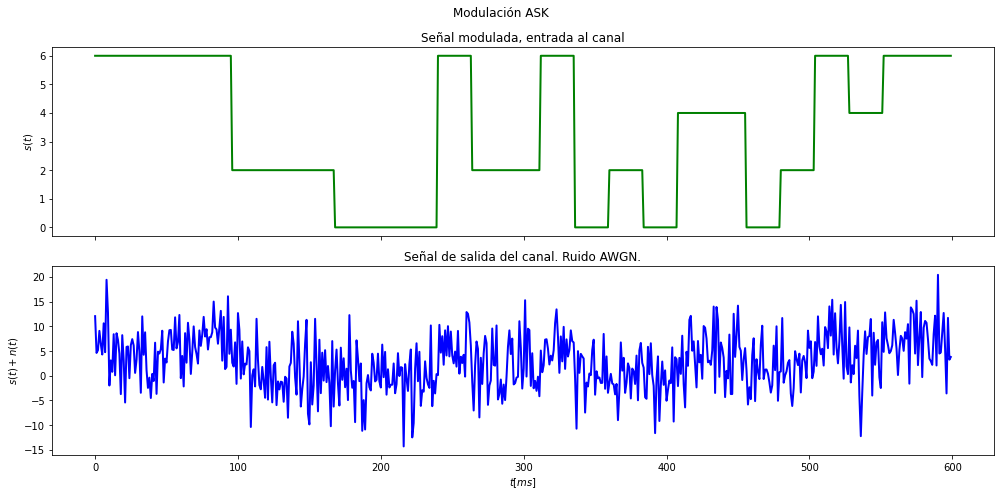

In [14]:
import matplotlib.pyplot as plt

# Visualizar las señales PAM
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(14, 7))

# Señal modulada
ax1.plot(x_k[0:600], color='g', lw=2)
ax1.set_ylabel('$s(t)$')
ax1.title.set_text('Señal modulada, entrada al canal')

# Señal modulada después del canal
ax2.plot(senal_xR[0:600], color='b', lw=2)
ax2.set_ylabel('$s(t) + n(t)$')
ax2.title.set_text('Señal de salida del canal. Ruido AWGN.')
ax2.set_xlabel('$t [ms]$')
fig.suptitle('Modulación ASK')
fig.tight_layout()
plt.show()

## Simulación ASK

Se realiza la simulación de todo el sistema de comunicación: modulador, canal ruidoso, demodulador, decodificador de canal y decodificador de fuente. En este caso se utiliza la modulación ASK de orden 4. En este caso, el codificador de fuente y de canal se utiliza la misma información obtenida de la simulación anterior, ya que serían los mismos bits.

In [ ]:
# 1. Se definen las variables de la modulación
t_simb = 0.04
fs = 1000

# 2. El proceso hasta la codificación de canal es igual. Se empieza con la modulación ASK
modulated_signal_ASK, tiempo = modulador_ASK(secuencia_codificada, fs, t_simb)

# 3. Se pasa la señal modulada por el canal ruidoso
AWGN_signal_ASK = canal_ruidoso(modulated_signal_ASK, snr=1)

# 4. Se procede a la demodulación, donde se tiene que enviar la cantidad de símbolos.
ordenModulador = 2
cant_simb = len(secuencia_codificada)/ordenModulador
demodulated_signal_ASK = demod_ASK(AWGN_signal_ASK, cant_simb, t_simb, fs)

# 5. Se sigue con la decodificación de canal para este nuevo método de modulación.
decoded_signal_ASK = decodificacion_canal(demodulated_signal_ASK, H)

# 6. Se procede con la decodificación de fuente. (bits -> pixeles)
photo_ASK = bits_a_pixel(decoded_signal_ASK, dimensiones)

# 7. Imagen recibida. (Sumidero de información)
new_photo = Image.fromarray(photo_ASK)
new_photo.save('ASK_output_komm.jpg')

## Simulación del sistema con ASK utilizando librería Komm.

En este caso, se realiza la misma modulación ASK pero utilizando la librería Komm. Esta librería facilita el proceso de modulación y demodulación de las señales. En este caso, para la modulación solo se necesita el array de bits proveniente del codificador de canal. Dentro de la función se realiza el proceso de bits -> símbolo y enviar una señal con amplitud multiplicada por el símbolo. En el proceso de demodulación se realiza igualmente el muestreo necesario, la asignación de símbolos según el valor obtenido (decisión) y finalmente se pasan los símbolos a bits. La documentación de esta librería se halla en: https://komm.readthedocs.io/en/latest/komm.ASKModulation/

In [13]:

# 1. Se llama a la clase de modulación ASk de la librería Komm

signal_ASK = komm.ASKModulation(4, base_amplitude=2)

# 2. Se utilza la función de modulación de la clase ASK. El parámetro de entrada es la secuencia de bits de salida del codificador de canal.
modulated_signal_ASK = signal_ASK.modulate(secuencia_codificada)

# 3. Se agrega ruido a la señal. El parámetro de entrada es la señal modulada.
AWGN_signal_ASK = canal_ruidoso(modulated_signal_ASK, snr=1)

# 4. Se utiliza la función de demodulación de la clase ASK. El parámetro de entrada es la señal con ruido proveniente del canal.
demodulated_signal_ASK = signal_ASK.demodulate(AWGN_signal_ASK)

# 5. Se sigue con la decodificación de canal para este nuevo método de modulación.
decoded_signal_ASK = decodificacion_canal(demodulated_signal_ASK, H)

# 6. Se procede con la decodificación de fuente. (bits -> pixeles)
photo_ASK = bits_a_pixel(decoded_signal_ASK, dimensiones)

# 7. Imagen recibida. (Sumidero de información)
new_photo = Image.fromarray(photo_ASK)
new_photo.save('ASK_output_komm.jpg')

## Visualización de señales con librería Komm.

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


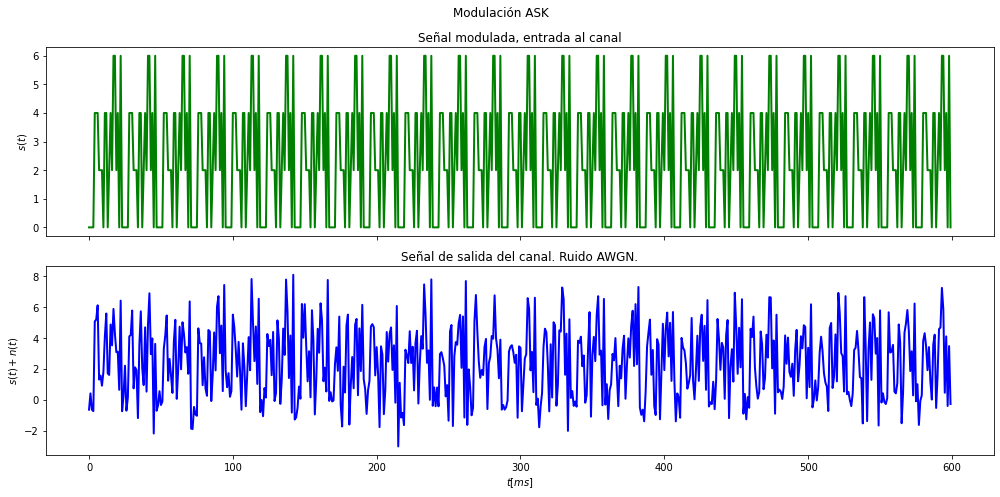

In [15]:
# Visualización de señales. Modulación ASK con Komm.
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(14, 7))

# Señal modulada
ax1.plot(modulated_signal_ASK[0:600], color='g', lw=2)
ax1.set_ylabel('$s(t)$')
ax1.title.set_text('Señal modulada, entrada al canal')

# Señal con ruido
ax2.plot(AWGN_signal_ASK[0:600], color='b', lw=2)
ax2.set_ylabel('$s(t) + n(t)$')
ax2.set_xlabel('$t [ms]$')
ax2.title.set_text('Señal de salida del canal. Ruido AWGN.')
fig.suptitle('Modulación ASK')
fig.tight_layout()
plt.show()